# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PHANzgz/embedded-deep-learning/blob/master/applications/person_detection/research/person-car-detection-research.ipynb)

In this notebook, I present the research and development of a multi-label neural network model for object detection(not localization, just present or not present). Specifically, the targeted devices for deployment are microcontrollers, so the model must be constrained.

I intend to train a small model to detect whether a person, a car, or both are present in an image. Note that **the following scripts can be used for different categories and applications**. Please check the rest of the repository to learn more and see the deployment phase to different microcontrollers.



# Setup

First, let's import all the libraries we will need and set some configuration parameters.

In [3]:
#Common imports
import numpy as np
import time, os, sys, random
import pathlib
import urllib.request
import shutil, zipfile, tarfile
import itertools
from collections import defaultdict

# Tables
import pandas as pd

#Deep learning
import tensorflow as tf
import tensorflow_addons as tfa # F1 metric
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Reproducibility
random.seed(23)
np.random.seed(23)
tf.random.set_seed(23)

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Dataset utilities
from pycocotools.coco import COCO

As you can see in the last import, we will use the `pycocotools` library to start building our data pipeline.

For reproducibility, here is some information of what I have installed:

In [4]:
# Record package versions for reproducibility
print("OS: {}".format(os.name))
print("Python version: {}".format(sys.version))
print("Numpy: {}".format(np.__version__))
print("Tensorflow: {}".format(tf.__version__))

OS: nt
Python version: 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 00:43:28) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.19.1
Tensorflow: 2.3.0


Finally, let's set up a couple of global variables

In [5]:
ROOT_PATH = "."
DATA_DIR = os.path.join(ROOT_PATH, "data")
coco_year = 2017

# Get the data

### Considerations

Unfortunately, the ImageNet dataset does not contain a class "person", so instead we can use the [COCO dataset](https://cocodataset.org/#home). On top of having the person class, the dataset name means "Common Objects in COntext" so, in theory, the images will be a better representation of the reality the model will be exposed to in the final application.

The visual wake word dataset would have been useful for this application if it could be extended to more than one foreground class, but it served as inspiration.

### Why COCO?
The application proposed in the repository talks about detecting pedestrians and vehicles in crossroads, so using a more specialized dataset should be the right choice. On the other hand, this is meant to be a demo to test at home or show to your employer or stakeholders before proceeding with the final application. Therefore, the COCO dataset is a great choice due to its context-rich images. It should be as easy as feeding the model a different dataset during the transfer learning phase to apply it to a similar task. At most, tuning some hyperparameters for fine-tuning.

### Getting more appropiate data for the demo
Iterating over the application I have realised we should get more data: For the car category we will use the [Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) to have a better representation of that class; For the negative class, we will add some indoor images from the [MIT Indoor dataset](http://web.mit.edu/torralba/www/indoor.html), as the model will be tested mostly indoors. The person category is already well represented in the COCO dataset.

### Execution
The COCO dataset is designed for a variety of deep learning applications, but classification is not one of them, so we will need to play with the COCO API to get the data in the format we want for **multi-label** classification.

The following class provides an easy interface to do just that, from downloading the original annotations and images to the conversion to a `tf.dataset` or `torch.utils.data.DataLoader` object for an optimized data pipeline. The information and comments provided should be enough to understand its API but do not forget to check the rest of the repository for the standalone script and more usage information.

In [6]:
class COCO_MLC():
    """
    COCO_C aims to convert the original COCO dataset into a classification problem. This approach
    makes the task easier and smaller models can be fit. Useful for constrained devices.
    
    Args:
        data_dir: Folder where all data will be downloaded
        year: COCO dataset year
    
    """
    def __init__(self, data_dir, year="2017"):
        self.data_dir = data_dir
        self.year = str(year)
        self.ANN_FOLDER = os.path.join(self.data_dir, "annotations")
        self.split_names = ["instances_train{}.json".format(self.year),
                            "instances_val{}.json".format(self.year)]
        self.coco_categories = []
        self.coco_objs = dict()
        self.datasets = []
        self.datasets_lens = []
        self.classes = []
        
        #self.filenames = dict(train=[], val=[])
        
        if not os.path.exists(self.data_dir):
            print("data_dir does not exist, creating directory now")
            os.makedirs(self.data_dir)
            
    def download_annotations(self, delete_zip=False):
        """
        Create annotations folder in data dir and download `year` COCO annotations.

        """
        ANN_ZIP_FILE_PATH = os.path.join(self.ANN_FOLDER, "annotations_train{}.zip".format(self.year))
        ANN_URL = r"http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(self.year)
        
        if not os.path.exists(self.ANN_FOLDER):
            print("Creating annotations folder: {}".format(self.ANN_FOLDER))
            os.makedirs(self.ANN_FOLDER)
        if not os.path.exists(ANN_ZIP_FILE_PATH):
            print("Downloading annotations...")
            with urllib.request.urlopen(ANN_URL) as resp, open(ANN_ZIP_FILE_PATH, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print ("... done downloading.")
        
        print("Unzipping {}".format(ANN_ZIP_FILE_PATH))
        with zipfile.ZipFile(ANN_ZIP_FILE_PATH,"r") as zip_ref:
            for split in self.split_names:
                split_zip_path = os.path.join("annotations", split)
                split_zip_path = split_zip_path.replace("\\", "/") # Needed by zipfile
                zip_ref.extract(split_zip_path, self.data_dir)
        print ("... done unzipping")

        if delete_zip:
            print("Removing original zip file...")
            os.remove(ANN_ZIP_FILE_PATH)
        print("... done")
        
        # Let's create a list of categories for the user to check
        val_ann_file = os.path.join(self.ANN_FOLDER, self.split_names[1])
        coco_obj = COCO(val_ann_file)
        cats = coco_obj.loadCats(coco_obj.getCatIds())
        self.coco_categories = [cat['name'] for cat in cats]
        
        print("Download annotations done")
        
    def download_images(self, classes=[], threshold_areas=[], only_length=False, max_length=None,
                       add_negative_class=True, neg_classes=[]):
        """
        Download images from the desired classes and store them in different folders. For example, 
        after running `download_annotations` and then this function with "person" and "car" classes,
        we end up with a tree that looks as follows:

        -- data_dir
            |-- annotations
            |-- train
            |   |-- car
            |   `-- person
            `-- val
                |-- car
                `-- person

        
        Args:
            classes: classes from which to download images
            threshold_areas: mininum area percentage the desired foreground object
                            must have to be downloaded. A threshold must be provided for each
                            class
            only_length: when True, it does not download the images
            max_length: the max number of COCO annotations to scan for. By default scans all.
                        This is useful when you want to get only a few downloaded images when 
                        trying new 'threshold_area' values. Note that in COCO dataset there is 
                        usually more than one annotation per image, so this parameter is not 
                        the amount of images to be downloaded, although the more annotations 
                        you scan, the more images will be downloaded, allsatisfying the 
                        `threshold_area` constraint.
            add_negative_class: when True, it downloads images that do not correspond to any 
                        of the `classes`. It downloads as many as needed to have a balanced 
                        dataset.
            neg_classes: COCO categories that will end up in the negative class. If empty,
                        it will use all remaining categories not in `classes`. It will
                        contain equal amount of each negative class(balanced).
        
        Returns:
            A dictionary with keys "train" and "val" that contains per split per
            category data length
        
        """
        if not classes:
            return
        self.classes = classes
        split_dirs = ["train", "val"]
        data_lens = {"train":[], "val":[]}
        
        for split, split_dir in zip(self.split_names, split_dirs):
            split_path = os.path.join(self.ANN_FOLDER, split)
            coco = COCO(split_path) # Should we make these class attributes? What about memory?
            self.coco_objs[split_dir]=coco
            cat_ids = coco.getCatIds(self.classes)
            for cat_id, cat_name, threshold_area in zip(cat_ids, self.classes, threshold_areas):
                print("Downloading {} data for {} category".format(split_dir, cat_name))
                cat_path = os.path.join(self.data_dir, split_dir ,cat_name)
                os.makedirs(cat_path, exist_ok=True)
                
                # load annotations
                ann_ids = coco.getAnnIds(catIds=[cat_id])[:max_length]
                anns = coco.loadAnns(ann_ids)
                
                # Check area threshold and create img data list
                imgs_data=[]
                for ann in anns:
                    img_id = ann["image_id"]
                    img = coco.loadImgs([img_id])[0]
                    img_area = img["height"] * img["width"]
                    normalized_object_area = ann["area"]/img_area
                    if normalized_object_area > threshold_area:
                        if img not in imgs_data: # Same image can have several annotations
                            imgs_data.append(img)
                
                N = len(imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                    
                # Download images
                tic = time.time()
                for i, img in enumerate(imgs_data):
                    fname = os.path.join(cat_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
                
            if add_negative_class:
                print("Downloading {} data for negative category".format(split_dir, cat_name))
                neg_path = os.path.join(self.data_dir, split_dir, "negative")
                os.makedirs(neg_path, exist_ok=True)
                
                # Obtain the number of images per class to get a balanced negative class
                if not neg_classes:
                    # all categories except the positive ones
                    all_cats = coco.loadCats(coco.getCatIds())
                    neg_classes = set([cat["name"] for cat in all_cats]) - set(self.classes)   
                    
                #neg_len = np.array(data_lens[split_dir], dtype=np.int64).mean(dtype=np.int64)
                neg_len = max(data_lens[split_dir])
                imgs_per_class = max(1, neg_len / len(neg_classes))
                
                # The COCO API has an attribute of type dictionary where each category_id key maps to
                # all images_ids of that class. Let's use that to make sets.
                
                # Get the positive image ids, we use sets to avoid duplicates.
                pos_classes_img_ids = set()
                for cat_id in cat_ids:
                    pos_classes_img_ids |= set(coco.catToImgs[cat_id])
                
                neg_classes_id = coco.getCatIds(neg_classes)
                
                # Find non negative images that do not contain positives and add `imgs_per_class` from
                # each subclass to the negative one.
                neg_images_ids = []
                for nclass_id in neg_classes_id: # TODO(Look for a better way)
                    n_subclass_imgs = set(coco.catToImgs[nclass_id])
                    n_subclass_imgs -= pos_classes_img_ids
                    imgs_to_sample = imgs_per_class if len(n_subclass_imgs)>imgs_per_class \
                                    else len(n_subclass_imgs)
                    n_subclass_imgs = random.sample(tuple(n_subclass_imgs), int(imgs_to_sample))
                    neg_images_ids.extend(n_subclass_imgs)
                
                neg_imgs_data = coco.loadImgs(neg_images_ids)
                N = len(neg_imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                
                # Download negative images
                tic = time.time()
                for i, img in enumerate(neg_imgs_data):
                    fname = os.path.join(neg_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
        if add_negative_class:
            self.classes.append("negative")
        return data_lens
    
    
    def to_tf_dataset(self, img_size=(240, 320), channels=3, batch_size = 32, normalize=False, \
                      max_class_len=[]):
        """
        Get `tf.data.Dataset` object from all the images downloaded in a convenient format for
        the train and validation splits.
        
        Args:
            img_size: this is the size (heigh, width) the images will be resized to
            channels: indicates the desired number of color channels for the output images. 
                      Accepted values are: 0 for automatic, 1 for grayscale, 3 for RGB.
            batch_size: the number of examples per batch
            normalize: whether to normalize the images to the [-1,1] range
            max_class_len: If specified, limit the per class examples(chosen randomly) to a fixed number. 
                      Must be a list of two elements(train and validation max class lengths). If None, 
                      there is no limit.
            
        Returns:
            train_ds: tf.data.Dataset for the train split where each element is a tuple; the first
                      element is the images with shape(batch_size, img_height, img_width, channels)
                      and the second is the labels with shape (batch_size, num_classes). Each label
                      is a vector with ones on the category indexes the image corresponds to and
                      zero otherwise.
            val_ds: tf.data.Dataset for the validation split that shares the same format as `train_ds`
            class_names: array containing the class names, with its indexes matching the datasets
                      labels.
            datasets_lens: list containing the train and val dataset lengths(number of examples), in 
                      that order.
        """
        # If you know how to improve this function please let me know or make a pull request
        # For convenience, lets use pathlib
        data_dir = pathlib.Path(self.data_dir)
        #class_names = np.array(self.classes) # Alternative
        class_names = np.array(sorted([item.name for item in data_dir.glob('train/*')])) 
        
        #Let's define a couple of inner functions we will use later
        def to_img_name(s):
            # This is used to go from a full path like data/train/person/001.jpg
            # to just 001.jpg
            return str(s).split(os.path.sep)[-1]
        
        def process_path(file_path, img_width, img_height):
            # A function to load an image from a path
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=channels)
            img = tf.image.resize(img, [img_height, img_width])
            return tf.cast(img, dtype=tf.uint8)
        
        def configure_for_performance(ds, img_batch_size):
            # Configure a tf.data.Dataset for performance
            #ds = ds.cache() # This fills up too much memory, prefetch should be fine
            #ds = ds.shuffle(shuffle_buf_size) # already done before
            ds = ds.batch(img_batch_size)
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            return ds
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        split_dirs = ["train", "val"]
        datasets = [] # this is where the tf datasets will be stored
        self.datasets_lens = []
        for split_ix, split in enumerate(split_dirs):
            img_filen = [] # tuple list where each pair is (image_filename, class_index)
            for i, class_n in enumerate(class_names):
                # For each class, get a list of all images in the corresponding folder and
                # make a tuple with its class index.
                pattern = "{}/{}/*.jpg".format(split, class_n)
                class_filen = [(filen, i) for filen in map(to_img_name, data_dir.glob(pattern))]
                if max_class_len:
                    # To avoid bias, we shuffle the filenames before slicing
                    random.shuffle(class_filen)
                    class_filen = class_filen[:max_class_len[split_ix]]
                img_filen += class_filen
                # for example, an element would now look like ('000000003711.jpg', 0)
            
            # Now we have to merge duplicate image files with different labels. To do so, we can
            # use a dictionary where each image filename is a key and the values are a list of
            # class indexes
            merged_dict = defaultdict(list)
            for filen, label in img_filen:
                merged_dict[filen].append(label)
            #Lets convert it back to a list
            img_filen = list(merged_dict.items())
            # an element with more than one class would now look like ('000000005205.jpg', [0, 2])
            self.datasets_lens.append(len(img_filen))
            
            # Now we need to reconstruct the full image filepath(to one of them) and encode the
            # labels as "multi-label one hot"
            for ix, elem in enumerate(img_filen):
                filen, labels = elem
                # Images with multiple labels have multiple possible filepaths(i.e. 
                # they exist in different categories) so we will take the first one,
                # for example.        
                class_n = class_names[labels[0]]
                full_path = data_dir / split / class_n / filen
                
                # The label has 1s wherever the index class corresponds to the example
                label = np.zeros(len(class_names),)
                label[labels] = 1
                
                img_filen[ix] = [str(full_path), label]
            # an element with more than one class would now look like
            # ()'data\\train\\car\\000000003711.jpg', array([1., 0., 0.]))            
            # Let's start creating the filename dataset
            filenames, labels = zip(*img_filen)
            filenames, labels = list(filenames), np.array(labels, dtype=np.float32) # for tf.data
            dataset = tf.data.Dataset.from_tensor_slices( (filenames, labels) )
            # This is a good time to shuffle the dataset, before loading the images.
            # This allows us to shuffle with a buffer as big as len(filenames)
            dataset = dataset.shuffle(buffer_size = len(filenames))
            
            # Let's use process_path() to get the image dataset
            h, w = img_size
            dataset = dataset.map(lambda x, y: (process_path(x, w, h), y), \
                                  num_parallel_calls=AUTOTUNE)
            if normalize:
                normalize = lambda img : (tf.cast(img, tf.float32) / 127.5)-1
                dataset = dataset.map(lambda x, y: (normalize(x), y), \
                                  num_parallel_calls=AUTOTUNE)
            
            # Batch it and configure it for performance
            dataset = configure_for_performance(dataset, batch_size)
            
            datasets.append(dataset)
        
        self.datasets = datasets
        
        return (*self.datasets, class_names, self.datasets_lens)
    
    def to_torch_dataloader(self):
        assert True, "This function is not yet implemented."
        return


With that done, we can create a `COCO_MLC` instance and download the annotations of the original COCO dataset.

In [7]:
coco_mlc = COCO_MLC(DATA_DIR, coco_year)

In [7]:
coco_mlc.download_annotations(delete_zip=False)

Unzipping .\data\annotations\annotations_train2017.zip
... done unzipping
... done
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Download annotations done


Now we can download images for the categories we want. In this case, "person" and "car" are the classes of interest. We can also specify the percentage of area `threshold_areas` the object of interest must have in the image to get rid of the images where it is too small for each class. By default, it will also download a negative class; this is useful because there could be no people or cars in the image, so it is helpful for the model to have a class to specify that situation.

Exploring the COCO dataset on the official website, we can see that there are considerably more person images(66k) than car images(12k), so to help reduce that imbalance we set a lower threshold area for the car class.

In [226]:
classes = ["person", "car"]
threshold_areas = [0.05, 0.01]
class_lengths = coco_mlc.download_images(classes, threshold_areas=threshold_areas, \
                         add_negative_class=False) # negative class already downloaded in my case

loading annotations into memory...
Done (t=21.84s)
creating index...
index created!
Downloaded 37585/37585 images (t=13.31s)

Downloaded 6263/6263 images (t=2.38s)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Downloaded 1565/1565 images (t=0.55s)

Downloaded 254/254 images (t=0.08s)



## Dealing with class imbalance

Let's check how many images per split and per class we have:

In [227]:
class_lengths

{'train': [37585, 6263], 'val': [1565, 254]}

Each list corresponds to the number of images of person, car, and negative classes on each split, respectively. It is clear we have an imbalanced dataset. There are several approaches to this problem, some of them are:

- Get more data (obvious but sometimes overlooked)
- Oversampling, making copies of the under-represented class images.
- Undersampling, deleting instances from the over-represented class.
- _Generate_ synthetic data, using algorithms like SMOTE or even a GAN.
- Setting class weights, although training may produce abrupt steps.

Iterating over this step, I have realized the car class is not entirely well represented in the dataset, as reflected in the precision and recall of that class, so we need to get more data first. If you browse the car folder, you will quickly see how some images have blurred or occluded cars; and that is not entirely bad to make the model more sensitive, but more samples with a car in the foreground will help improve performance and meet our end application goals. Although it doesn't have the context variety of the COCO dataset, the [Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) should work just fine.

After that, since we will use transfer learning techniques we will stick to the undersampling option, limiting the number of examples for training to `6263+12000=18263` which is the minimum of examples for a class(car) plus the car images we will add from the Cars dataset. This means we will throw away a lot of precious data, but we can always come back and try an alternative if the application performance does not meet its goals, as we have just done. Nevertheless, with only three classes and a pre-trained model we should be all right now.

To get more data, we will download `12000` training samples and `4185` validation samples for the car class. Let's write a function that will both download the images and copy them the respective folders `data_dir/train/car` and `data_dir/val/car`:

In [8]:
def download_and_merge_car_dataset(data_dir, n_train, n_val):
    """
    Download the cars dataset (https://ai.stanford.edu/~jkrause/cars/car_dataset.html) and copy `n_train`
    examples to data_dir/train/car and `n_val` examples to data_dir/val/car. The data downloaded is both the
    train and val split from the cars dataset, which together have 8144+8041=16185 examples. Therefore, 
    `n_train + n_val` should not exceed that quantity to prevent overlapping.

    Args:
        data_dir: data folder path
        n_train: number of train examples to copy to the destination folder data_dir/train/car
        n_val: number of val examples to copy to the destination folder data_dir/val/car

    """
    dataset_path = os.path.join(data_dir, "cars_dataset")
    if not os.path.exists(dataset_path):
        print("Creating cars_dataset folder")
        os.makedirs(dataset_path)
    
    zip_filepaths = [os.path.join(dataset_path, "cars_train.tgz"),
                    os.path.join(dataset_path, "cars_test.tgz")]
    zip_urls = ["http://imagenet.stanford.edu/internal/car196/cars_train.tgz",
                "http://imagenet.stanford.edu/internal/car196/cars_test.tgz"]
    
    for zip_filepath, zip_url in zip(zip_filepaths, zip_urls):
        if not os.path.exists(zip_filepath):
            print("Downloading dataset...")
            with urllib.request.urlopen(zip_url) as resp, open(zip_filepath, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print ("... done downloading.")

        print("Unzipping {}".format(zip_filepath))
        with tarfile.open(zip_filepath, "r") as fc:
            fc.extractall(dataset_path)
    
    dataset_path = pathlib.Path(dataset_path)
    car_filenames_gen = itertools.chain(dataset_path.glob("cars_train/*"),
                                       dataset_path.glob("cars_test/*"))
    car_filenames = ["/".join(str(fn).split(os.path.sep)[-2:]) for fn in car_filenames_gen]

    cars_train = car_filenames[:n_train]
    cars_val = car_filenames[-n_val:]
    data_dir = str(pathlib.Path(data_dir))

    print("Copying {} train examples".format(n_train))
    for fn in cars_train:
        # we need a way to give different names to tRain and tEst images, so we use "r" or "e"
        split_id =fn.split("/")[0][6] 
        src = "{}/cars_dataset/{}".format(data_dir, fn)
        dst = "{}/train/car/{}".format(data_dir, "car"+split_id+fn.split("/")[1])
        shutil.copy(src, dst)
        #os.remove(dst)

    print("Copying {} validation examples".format(n_val))
    for fn in cars_val:
        split_id =fn.split("/")[0][6] 
        src = "{}/cars_dataset/{}".format(data_dir, fn)
        dst = "{}/val/car/{}".format(data_dir, "car"+split_id+fn.split("/")[1])
        shutil.copy(src, dst)
        #os.remove(dst)

    print("Done")

In [166]:
download_and_merge_car_dataset(DATA_DIR, n_train=12000, n_val=4185)

Unzipping .\data\cars_dataset\cars_train.tgz
Unzipping .\data\cars_dataset\cars_test.tgz
Copying 12000 train examples
Copying 4185 validation examples
Done


You may have noticed the validation data is quite imbalanced. Since we are using the undersampling option we can move some training images from the undersampled classes to the validation folder without any problem. First let's see how many images per train and class we currently have:

In [9]:
def print_data_filecounts():
    class_ns = os.listdir(os.path.join(DATA_DIR, "train"))
    for split_name in ["train", "val"]:
        print("{}".format(split_name))
        for class_n in class_ns:
            filecount = len(os.listdir(os.path.join(DATA_DIR, split_name, class_n)))
            print("\t{:9}: {:>5}".format(class_n, filecount))

In [283]:
print_data_filecounts()

train
	car      : 18263
	negative : 27653
	person   : 37576
val
	car      :  4439
	negative :  1018
	person   :  1565


Let's move some images from the person and negative training images to the corresponding validation ones

In [9]:
def move_images_to_val(data_dir, classes=[], n_per_class=[]):
    
    path_data_dir = pathlib.Path(data_dir)
    
    to_filename = lambda fp : (fp.parts[-1])
    to_new_fp = lambda fl, classname : (path_data_dir / "val" / classname / fl)
    
    for i, class_n in enumerate(classes):
        class_fp = list((path_data_dir / "train" / class_n).glob("*"))
        #random.shuffle(class_fp)
        class_fn = map(to_filename, class_fp)
        new_fp = [to_new_fp(fn, class_n) for fn in class_fn]
        
        class_fp = list(map(str, class_fp))[-n_per_class[i]:]
        new_fp = list(map(str, new_fp))[-n_per_class[i]:]
        
        for src, dst in zip(class_fp, new_fp):
            os.rename(src, dst)

In [285]:
move_images_to_val(DATA_DIR, ["negative", "person"], [3421, 2874])

In [286]:
print_data_filecounts()

train
	car      : 18263
	negative : 24232
	person   : 34702
val
	car      :  4439
	negative :  4439
	person   :  4439


## Tuning the negative class

If you check the negative class it contains only a few images containing indoor scenes. This could(and has during previous iterations) lead to overestimating the person category, as a significant amount of person images are indoors. To combat this, we need to provide negative data that contains an indoor scene without people(or cars) in the images. To do so, we can download the [MIT Indoor dataset](http://web.mit.edu/torralba/www/indoor.html) and choose the indoor scenes we would like to add to our negative class.

In [34]:
def download_indoor_data(data_dir):
    dataset_path = os.path.join(data_dir, "indoor_scene_dataset")
    if not os.path.exists(dataset_path):
        print("Creating indoor_scene_dataset folder")
        os.makedirs(dataset_path)
    
    zip_filepath = os.path.join(dataset_path, "indoorCVPR_09.tar")
    zip_url = "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"
        
    if not os.path.exists(zip_filepath):
        print("Downloading dataset...")
        with urllib.request.urlopen(zip_url) as resp, open(zip_filepath, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")

    print("Unzipping {}".format(zip_filepath))
    with tarfile.open(zip_filepath, "r") as fc:
        fc.extractall(dataset_path)

In [14]:
download_indoor_data(DATA_DIR)

Unzipping .\data\indoor_scene_dataset\indoorCVPR_09.tar


After inspecting the dataset I have chosen the following categories to be included in the negative class. Please note that I have manually deleted some images that contained people on them, but they mostly do not.

In [23]:
indoor_categories = ["bathroom", "bedroom", "children_room", "classroom", "closet",
                    "computerroom", "corridor", "dining_room", "gameroom", "hairsalon", 
                    "kitchen", "library", "livingroom", "lobby", "meeting_room", "office",
                    "stairscase", "studiomusic", "waitingroom"]

In [24]:
img_count = 0
for indoor_cat in indoor_categories:
    img_count += len(os.listdir(os.path.join(DATA_DIR, "indoor_scene_dataset", "Images", indoor_cat)))

print("Total new image count: {}".format(img_count))

Total new image count: 4654


Let's add `4000` images to the train set and `654` to the validation one. Since we are undersampling, we have to make sure we choose our new images for training. To do that, let's first move as many images from the negative folder to an "unused" folder in order to leave space for our new images. Our maximum number of examples per class is `18263` and currently the negative folder image has `24232` images as shown above, so we have to move `24232 - 18263 + 4000 = 9969` images. For validation we will just add the images as the imbalance would not be too significant(negative class will be 36% of the total validation data).

In [59]:
n_new_neg_train = 4000
n_new_neg_val = 654
max_examples = 18263 # in my case len(os.listdir(os.path.join(DATA_DIR, "train", "car")))

n_neg_train = len(os.listdir(os.path.join(DATA_DIR, "train", "negative")))

n_move_to_unused = n_neg_train - max_examples + n_new_neg_train

In [63]:
n_move_to_unused

9969

In [101]:
def swap_negative_examples(data_dir, n_move_to_unused, indoor_cats, n_train):
    
    neg_train_folder = os.path.join(data_dir, "train", "negative")
    neg_val_folder = os.path.join(data_dir, "val", "negative")
    unused_folder = os.path.join(data_dir, "unused")
    
    if not os.path.exists(unused_folder):
        os.makedirs(unused_folder)
    
    neg_filenames = os.listdir(neg_train_folder)[-n_move_to_unused:]
    neg_src = [os.path.join(neg_train_folder, img_name) for img_name in neg_filenames]
    unused_dst = [os.path.join(unused_folder, img_name) for img_name in neg_filenames]
    
    for src, dst in zip(neg_src, unused_dst):
        os.rename(src, dst)
        
    indoor_folder = os.path.join(data_dir, "indoor_scene_dataset", "Images")
    indoor_filenames_with_cat = []
    
    for cat in indoor_cats:
        cat_filenames = os.listdir(os.path.join(indoor_folder, cat))
        cat_filenames_with_cat = [os.path.join(cat, filename) for filename in cat_filenames]
        indoor_filenames_with_cat.extend(cat_filenames_with_cat)
    
    random.shuffle(indoor_filenames_with_cat)
    indoor_filenames = [filepath.split(os.path.sep)[1] for filepath in indoor_filenames_with_cat]
    
    def index_generator():
        for i in range(n_train):
            yield str(i).zfill(4)
            
    indoor_src = [os.path.join(indoor_folder, img_name) for img_name in indoor_filenames_with_cat]
    neg_dst_train = [os.path.join(neg_train_folder, "ind"+ix+"_"+img_name) 
                     for ix, img_name in zip(index_generator(), indoor_filenames[:n_train])]
    neg_dst_val = [os.path.join(neg_val_folder, "ind"+ix+"_"+img_name) 
                   for ix, img_name in zip(index_generator(), indoor_filenames[n_train:])]
    
    for src, dst in zip(indoor_src, [*neg_dst_train, *neg_dst_val]):
        shutil.copy(src, dst)
        

In [102]:
swap_negative_examples(DATA_DIR, n_move_to_unused, indoor_categories, n_new_neg_train)

In [103]:
print_data_filecounts()

train
	car      : 18263
	negative : 18263
	person   : 34702
val
	car      :  4439
	negative :  5093
	person   :  4439


## Creating the dataset object

With that done, since we are using tensorflow and keras, we create the `tf.data.Dataset`s for the train and validation splits. We want the images to be normalized in the range `[-1,1]` and since the main target for the application features a relatively powerful ARM Cortex-M7 processor we will leave the image channels to `3`(RGB). We will start with an image size of `(224, 224)`. Finally, as described just above, we can use the `max_class_len` parameter to limit the number of examples per class. For validation we will not apply that limit though(setting it to `None`), we will just have to choose wisely the metrics for model evaluation.

>Note: This function scans for files the folder structure `COCO_MLC.download_images` created, and that's why it will also take into account the Cars and Indoor scenes dataset's images we have just added.

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)
max_examples = 18263

In [11]:
dataset_params = dict(
    img_size = IMG_SIZE,
    channels = 3,
    normalize = True,
    batch_size = BATCH_SIZE,
    max_class_len = [max_examples, None]
)

train_ds, val_ds, class_names, datasets_lens = coco_mlc.to_tf_dataset(**dataset_params)

It seems one of the images was corrputed and was giving errors when decoding, here is the code snippet I used to find it in case you face the same problem. Run the above cell again if you delete any image to create a new dataset object.

In [12]:
"""
val_neg_fn = [os.path.join(DATA_DIR, "val", "negative", fn) for fn in os.listdir(os.path.join(DATA_DIR, "val", "negative"))]

for fn in val_neg_fn:
    try:
        img_jpeg = tf.io.read_file(fn)
        img = tf.io.decode_jpeg(img_jpeg)
    except:
        print(fn)
"""
None

# Explore the data

Let's take a moment to actually see the data we are working with. The number of examples per class and split is

In [181]:
def get_exs_per_class(dataset):
    class_counts = np.array([0, 0 , 0])
    for image_batch, label_batch in iter(dataset):
        for i in range(len(label_batch)):
            label = label_batch[i]
            label_ixs = tf.where(label).numpy()
            class_counts[label_ixs] += 1
    return class_counts
    
print("Train examples per class:  {}".format(get_exs_per_class(train_ds)))
print("Val examples per class:  {}".format(get_exs_per_class(val_ds)))

Train examples per class:  [18263 18262 18263]
Val examples per class:  [4439 5092 4439]


The classes with the correct index are

In [123]:
print(class_names)

['car' 'negative' 'person']


Great! Now let's see some images

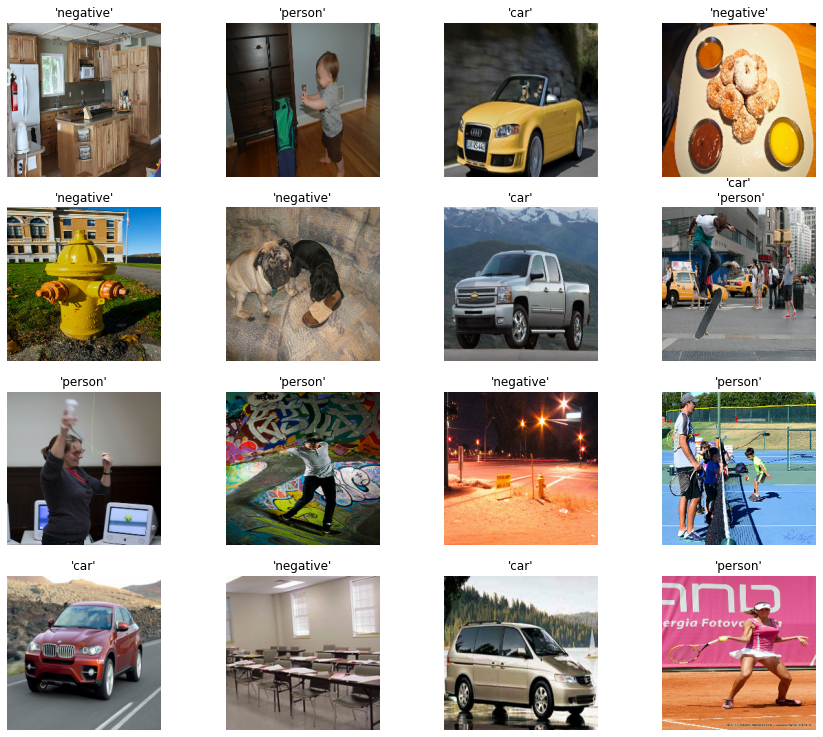

In [96]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(15, 13))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = ((image_batch[i].numpy()+1)*127.5).astype("uint8") # channels = 3
    plt.imshow(img) # channels = 3
    #img = (tf.squeeze(image_batch[i]).numpy()) # channels = 1
    #plt.imshow(img, cmap='gray') # channels = 1
    label = label_batch[i]
    label_ixs = tf.where(label).numpy()
    plt.title(str(class_names[label_ixs]).replace("[", "").replace("]",""))
    plt.axis("off")
plt.show()

As we can see, some images have multiple classes, and some just correspond to the negative one. Let's proceed to the model selection step.

# The model

While doing some research, I came across [these amazing tables](https://github.com/nerox8664/awesome-computer-vision-models) containing lists of computer vision models for different tasks, with some characteristics like performance or number of parameters. I exported the classification model table and filtered them with the following criteria:
- A microcontroller has limited flash and RAM memory, so a model with a low number of parameters is needed.
- They also have a limited clock speed, so the number of floating-point operations(FLOPS) should not be too high.
- Since we will be doing transfer learning, a pre-trained model should be available.

These are the top five models meeting those filters and sorted by top one error rate:

In [171]:
best_small_models = pd.read_csv("parsed_classification_models.csv")[:5] # utils.ipynb has the filtering code
best_small_models.iloc[:5,1:]

,Model,Number of parameters,FLOPS (millions),Top-1 Error,Top-5 Error,Year
0,EfficientNet-B0,"5,288,548",414.31,24.77,7.52,2019
1,NASNet-A 4@1056,"5,289,978",584.90,25.68,8.16,2017
2,MobileNet,"4,231,976",579.80,26.61,8.95,2017
3,MobileNetV2,"3,504,960",329.36,26.97,8.87,2018
4,ShuffleNetV2,"2,278,604",149.72,31.44,11.63,2018


The main target for this application is an STM32H7 microcontroller, with generous 2MB of flash memory and 1MB of RAM. Those are really high-end specifications for a microcontroller. Still, none of the models in that list would fit those constraints, at least not in their original form. Both [EfficentNet](https://arxiv.org/abs/1905.11946) and [NASNet](https://arxiv.org/abs/1707.07012) shine on mobile applications, but [MobileNet](https://arxiv.org/abs/1704.04861) and [MobileNetV2](https://arxiv.org/abs/1801.04381) apart from performing nearly as well, they propose two hyperparameters that affect the model complexity and capacity and, in turn, size and latency.

### MobileNets
The MobileNet architecture was first proposed by Google in 2017 and showed how small and quick models could achieve near state of the art performance. The main idea is the use of depthwise separable convolution layers instead of the standard ones: First, a filter is applied to **one and each** input channel(i.e. spatially). Then, a 1x1 filter is applied to all of the resulting feature maps across the channels(i.e. depthwise). For a more visual and rigorous explanation please refer to the paper or the repository.

It can be shown that the computational cost ratio between depthwise separable convolution and standard convolution is:

$$ r = \frac{1}{N} + \frac{1}{D^{2}_{k}} $$

Where $N$ is the number of output channels and $D_k$ is the kernel(filter) height and width. With $N$ being typically in the range of [32, 1024] and the kernel sizes for depthwise separable convolutions being always $3\times3$, they need 7 o 9 times fewer computations than standard convolutions. Of course, another way of reducing the computational cost is feeding a smaller image to the input, which is also shown in the paper.

As for the model size, while MobileNet already has relatively few parameters(around four million) we can push them a lot further down with a "width multiplier": For a given layer and width multiplier $\alpha$, the number of input channels $M$ becomes $\alpha M$ and the number of output channels $N$ becomes $\alpha N$. It can also be shown that the computational cost and number of parameters is reduced by _roughly_ a factor of $\alpha^2$.

MobileNetV2 was proposed in 2019 and iterates over its predecessor adding new concepts like inverted residuals or linear bottlenecks, improving the performance on popular datasets and keeping, and __even smaller footprint__.

### Baseline model

The good thing is that Keras has pre-trained MobileNets(V1 and V2) with different `alpha`s, so we can use those pre-trained models and see which one fits our needs.

I've already gone ahead and trained a few baseline models with "out of the box" hyperparameters with different MobileNet versions and depths to get an idea of the performance we will be getting. I manually wrote the results in a CSV file which we will be filling with the different architectures and hyperparameters we try. This is what I got:

In [172]:
model_selection = pd.read_csv("model_selection.csv")
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.8407,0.8171,0.9422,-1,-1,-1,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.8594,0.8298,0.9524,-1,-1,-1,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.8436,0.8290,0.9494,-1,-1,-1,Adam,RMSProp,0.0001,0.00001


> Note: this baseline models were trained before getting more data(i.e. with much fewer images)

Loss `BCE` refers to binary cross-entropy. The optimizers and learning rates are different during transfer learning and fine-tuning. The `n_dense` refers to the number of neurons in the fully connected layer after the base model. The training accuracy is quite decent given that the COCO dataset is quite diverse and some of the images have blurred or occluded elements(try browsing the data folder if you've downloaded it). For a more context-specific scenario, like pedestrian and vehicle detection in crossroads, the model would definitely perform better if fed a good specific dataset. The validation accuracy is quite close to the training one, showing it hasn't overfitted. We will be looking at different metrics for validation soon.

The model size though is clearly a problem: With `alpha` higher or equal than `0.5` the model is too close or surpasses the flash memory limit. Still, and this is what makes MobileNets really powerful, is that they scale down quite nicely; with `alpha=0.35` in MobileNetV2 and `n_dense=256` the model fits in less than 1.5MB, leaving 500 kilobytes for the application, which should be enough if it is not too complex. It is important to note that the size refers to the model _quantized_ to 16-bit floats, meaning that the original parameters have been shrunk from 32-bit floats to 16-bit ones. The precision loss is not really important during inference and it gives us a x2 size reduction, so it is definitely worth it. One can also quantize the model to 8-bit integers, which is what we will end up doing to get the smallest footprint, sacrificing as less performance as possible. This also reduces RAM usage, which is the limiting factor in our application.

Although MobileNetV2 tend to work better the tensorflow lite for microcontrollers does not support all of the operations needed in that model(October 2020). Specifically, it is the number of convolutional depthwise channels that is limited to `256`. Thankfully, MobileNetV1 with $\alpha=0.25$ will just meet that constraint.

### Loss and metrics

Before delving deeper into the model creation I would like to discuss the model's metrics and loss. For the metrics, we will be sticking with accuracy and F1 score. If you are not familiar with the latter, it is just the harmonic mean of the _precision_ and _recall_:  

$$ F_{1}=\frac{2}{\operatorname{recall}^{-1}+\text {precision }^{-1}} $$

If we decompose those terms in terms of true positives, false positives and false negatives, the F1 score looks like this:  

$$ F_1 = \frac{2\mathrm{tp}}{2\mathrm{tp} + \mathrm{fp}+\mathrm{fn}} $$

The harmonic mean is the equivalent of the arithmetic mean for reciprocals of quantities that should be averaged by the arithmetic mean. To give some intuition, think about how the reciprocals of both precision and recall share the same denominator(true positives), so when we sum those quantities we are actually getting the arithmetic mean of false positives and false negatives over true positives. Finally, we take the reciprocal of that sum to transform it to the original representation. Visually, we see that to keep a high $F_1$ score we need an equilibrium between precision and recall:

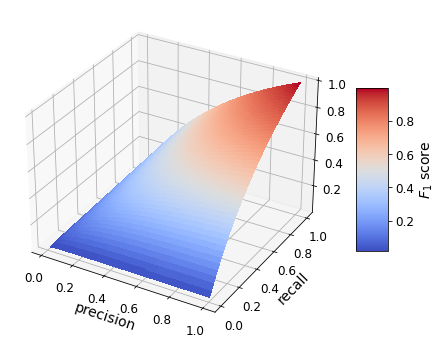

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

precision = np.linspace(0.01, 1, 100)
recall = np.linspace(0.01,1,100)
pp, rr = np.meshgrid(precision, recall)
f1 = 2/((1/pp)+(1/rr))

surf =ax.plot_surface(pp, rr, f1, cmap=mpl.cm.coolwarm,
                linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5, label="$F_1$ score")
ax.set_xlabel("precision")
ax.set_ylabel("recall")
plt.show()

For the multi-label classification task we can just take the average of each class' $F_1$ score, which we will call "macro $F_1$ score". We will a use a threshold of `0.5` for this metric.

Going one step further, I found [this amazing post](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d) explaining how one could even make a differentiable F1 function to use as loss. It also explains some of the benefits like optimizing directly for the macro $F_1$ score and the fact that the need for choosing a threshold to consider each class positive is implicitly inside the loss and we don't have to tweak those values. For more details and implementation details, I highly encourage you to check the post.

Nevertheless, although that sounds great we will also try the go-to loss function: binary cross-entropy, which maximizes the log-likelihood for each class and then we will see which one performs better for our task.

We can use the `metrics.F1Score` metric inside tensorflow-addons, but we'll have to define our own custom loss:

In [14]:
class MacroDoubleSoftF1(keras.losses.Loss):
    """
    Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    Credits to ashrfem in github.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    def __init__(self, name="macro_double_soft_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        
    def call(self, y_true, y_pred):
        y = tf.cast(y_true, tf.float32)
        y_hat = tf.cast(y_pred, tf.float32)
        
        tp = tf.reduce_sum(y_hat * y, axis=0)
        fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
        fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
        tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
        
        soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
        soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
        
        cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
        cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
        cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
        macro_cost = tf.reduce_mean(cost) # average on all labels
        
        return macro_cost

### Implementation and hyperparameter tuning

Transfer learning is the process of using parts of a pretrained network and fine-tuning its parameters to a new task. A common practice with CNNs is to keep the convolutional layers(with their weights frozen) and add a classification head, typically consisting of a fully connected layer and then the output layer. It's good practice to add some kind of regularization to prevent overfitting, as it is especially common in transfer learning(big model, little data). After training the classification head, we can unfreeze the rest(or part) of the network, which we will call feature extractor, and fine tune those weights. This last process can push the performance up a little bit but can also quickly overfit the data, so it must be done with caution.

Let's build a function to create a model with different hyperparameters and perform transfer learning with fine-tuning.

In [15]:
def build_model(pms, classification_report=True, class_names=[]):
    """
    Build and train a model with a given set of hyperparameters
    
    Args:
        pms: Dictionary with the hyperparameters, see examples for a template
        classification_report: wheter to return classification report generated by sklearn
        class_names: list with category names, used for the classification report
        
    Returns: 
        model: trained model
        history: data logged from keras model when fitting model during transfer learning
        history_fine: data logged from keras model when fitting model during fine tuning
    
    """
    # Load pretrained MobileNet on imageNet
    # MobileNets expect images with pixels in the range[-1,1]
    feature_extractor = keras.applications.MobileNet(input_shape=pms["img_shape"],
                                                alpha=pms["alpha"],
                                                weights='imagenet',
                                                include_top=False)
    # Freeze weights during transfer learning
    feature_extractor.trainable = False
    
    # Build the classification head
    pool_size = {(224,224,3):(7,7), (192,192,3):(6,6), (160,160,3):(5,5), (128,128,3):(4,4)}
    classification_head = keras.Sequential([
        keras.layers.InputLayer(feature_extractor.output.shape[1:]), # batch size doesn't have to be included
        #keras.layers.GlobalAveragePooling2D(), # instead of flatten 
        tf.keras.layers.AveragePooling2D(pool_size=pool_size[pms["img_shape"]]), #instead of flatten and returns 4D array, 
        # we use this because then we don't need to add reshape which adds SHAPE op, not supported by tflite micro
        #keras.layers.Dense(pms["n_dense"]), # no activation, like in the paper
        # tflite micro has issues with quantized fully connected so we make a FCN
        keras.layers.Conv2D(pms["n_dense"], kernel_size=1, padding='valid'),
        keras.layers.Dropout(pms["dropout"]),
        #keras.layers.Dense(pms["n_output"], activation="sigmoid") # multi label classification
        keras.layers.Conv2D(pms["n_output"], kernel_size=1, padding='valid', activation="sigmoid"),
        tf.keras.layers.Reshape([pms["n_output"]]) # we will get rid of this layer during deployment
    ], name="classification_head")
    
    # Build complete model using functional API
    inputs = tf.keras.Input(shape=pms["img_shape"])
    features = feature_extractor(inputs, training=False) # training=False to prevent BatchNorm parameters to be altered
    outputs = classification_head(features)
    model = tf.keras.Model(inputs, outputs)
    
    # Compile and fit
    tic = time.time()
    model.compile(optimizer=pms["base_opt"], loss=pms["loss"], metrics=pms["metrics"])
    print("Training classification head...\n")
    
    history = model.fit(pms["train_ds"], epochs=pms["base_epochs"], verbose=2,
                        validation_data=pms["val_ds"], callbacks=pms["callbacks"])
    print("\n\n")
    
    # Fine tune the model
    for layer in feature_extractor.layers[pms["fine_tune_layer_from"]:]:
        layer.trainable=True
    
    # Compile and fit
    fine_epochs = history.epoch[-1] + pms["fine_epochs"]
    model.compile(optimizer=pms["fine_opt"], loss=pms["loss"], metrics=pms["metrics"])
    print("Fine tuning...\n")
    
    history_fine = model.fit(pms["train_ds"], epochs=fine_epochs, validation_data=pms["val_ds"], verbose=2,
                             callbacks=pms["callbacks"], initial_epoch=history.epoch[-1])
    print("\n\n")
    
    delta = time.time() - tic
    print("Done, training took {}m {}s\n".format(int(delta//60), int(delta%60)))
    
    if classification_report:
        print("Classification report for validation split:")
        from sklearn.metrics import classification_report
        x_val, y_val, y_pred = [], [], []
        for x_batch, y_batch in pms["val_ds"]:
            x_val.extend(x_batch)
            y_val.extend(y_batch>0.5)
            y_pred.extend(model.predict(x_batch)>0.5)

        class_report = classification_report(y_val, y_pred, target_names=class_names, zero_division=1)
        print(class_report)
        
    return model, history, history_fine

#### Run 1

We'll use the custom loss we have defined and a dense layer with 256 neurons, with `dropout=0.3`. Let's see how it performs compared to our baselines.

In [186]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_MacroF1", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_01 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.25,
    n_dense = 256,
    n_output = 3,
    dropout = 0.3,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 57 # feature_extractor has 87 layers
    
)

run_2020_10_10-03_48_55


In [187]:
model_01, history_01, history_fine_01= build_model(pms_01, class_names=class_names)

Training classification head...

Epoch 1/25
1688/1688 - 65s - loss: 0.1568 - bin_accuracy: 0.8818 - precision: 0.8401 - recall: 0.8035 - MacroF1: 0.8318 - val_loss: 0.0910 - val_bin_accuracy: 0.9295 - val_precision: 0.8986 - val_recall: 0.8898 - val_MacroF1: 0.8998
Epoch 2/25
1688/1688 - 60s - loss: 0.1203 - bin_accuracy: 0.9024 - precision: 0.8622 - recall: 0.8468 - MacroF1: 0.8584 - val_loss: 0.0841 - val_bin_accuracy: 0.9325 - val_precision: 0.8994 - val_recall: 0.8990 - val_MacroF1: 0.9034
Epoch 3/25
1688/1688 - 59s - loss: 0.1145 - bin_accuracy: 0.9061 - precision: 0.8674 - recall: 0.8529 - MacroF1: 0.8625 - val_loss: 0.0804 - val_bin_accuracy: 0.9344 - val_precision: 0.9117 - val_recall: 0.8904 - val_MacroF1: 0.9070
Epoch 4/25
1688/1688 - 59s - loss: 0.1116 - bin_accuracy: 0.9075 - precision: 0.8694 - recall: 0.8550 - MacroF1: 0.8647 - val_loss: 0.0832 - val_bin_accuracy: 0.9324 - val_precision: 0.9026 - val_recall: 0.8947 - val_MacroF1: 0.9026
Epoch 5/25
1688/1688 - 59s - loss: 

That is actually pretty good for a <1.5MB model and significantly better than our baseline models. The foreground classes have similar precisions but the `person` class has considerably lower recall, which means the model may ignore a person is in the image when there actually is one. This should not be a problem in our demo application and after testing it, it is definitely not noticeable. Still, if we were to develop the pedestrian and vehicle detection, I would have chosen an $F$ score that gives more importance to recall, since it is better that the model doesn't act on the street light(pedestrians and vehicles are frequent) too easily. If it was tuned for precision, we would miss more events and maybe act on that(we detect no pedestrians so we turn the street light to flashing amber for cars to proceed).

It seems like our model is already doing quite well as seen in all of the metrics, but I'm curious to try other hyperparameters. Especially regarding model size.

Before continuing, let me define a small function to add the results to our `model_selection` table:

In [190]:
model_selection.iloc[:,5:12] = model_selection.iloc[:,5:12].round(3)
# Quick and not elegant function to add rows to our model_selection table
def log_results(model, history, version="V1", alpha=0.35, size=1.465, opt=["Adam", "RMSProp"], lr=[1e-4,1e-5]):
    #n_dense = model.layers[-1].layers[-3].units
    n_dense = model.layers[-1].layers[-4].filters
    rlog = history.history
    log = [version, alpha, n_dense, model.loss.name, size, max(rlog["bin_accuracy"]), max(rlog["val_bin_accuracy"]),
           -1., max(rlog["val_MacroF1"]), max(rlog["val_precision"]), max(rlog["val_recall"]), opt[0],opt[1],lr[0],lr[1]]
    return log

def add_entry(data=[]):
    model_selection.loc[len(model_selection)] = data
save_table = lambda: model_selection.to_csv("model_selection_complete.csv", index=False)
load_table = lambda: pd.read_csv("model_selection_complete.csv")

In [191]:
add_entry(log_results(model_01, history_fine_01))
save_table()

In [192]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V1,0.35,256,macro_double_soft_f1,1.465,0.915143,0.935309,-1.000,0.907874,0.906755,0.899642,Adam,RMSProp,0.0001,0.00001


#### Run 2

Let's switch back to the binary cross-entropy to make sure the macro double F1 loss performs better. The rest of the hyperparameters are left intact.

In [193]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_MacroF1", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_02 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.25,
    n_dense = 256,
    n_output = 3,
    dropout = 0.3,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 57 # feature_extractor has 87 layers
    
)

run_2020_10_10-04_08_28


In [194]:
model_02, history_02, history_fine_02= build_model(pms_02, class_names=class_names)

Training classification head...

Epoch 1/25
1688/1688 - 66s - loss: 0.3082 - bin_accuracy: 0.8700 - precision: 0.8259 - recall: 0.7803 - MacroF1: 0.8214 - val_loss: 0.1838 - val_bin_accuracy: 0.9273 - val_precision: 0.9071 - val_recall: 0.8722 - val_MacroF1: 0.8981
Epoch 2/25
1688/1688 - 59s - loss: 0.2491 - bin_accuracy: 0.8996 - precision: 0.8678 - recall: 0.8296 - MacroF1: 0.8590 - val_loss: 0.1752 - val_bin_accuracy: 0.9315 - val_precision: 0.9160 - val_recall: 0.8757 - val_MacroF1: 0.9037
Epoch 3/25
1688/1688 - 58s - loss: 0.2415 - bin_accuracy: 0.9027 - precision: 0.8713 - recall: 0.8358 - MacroF1: 0.8619 - val_loss: 0.1764 - val_bin_accuracy: 0.9292 - val_precision: 0.9140 - val_recall: 0.8707 - val_MacroF1: 0.9011
Epoch 4/25
1688/1688 - 57s - loss: 0.2386 - bin_accuracy: 0.9040 - precision: 0.8734 - recall: 0.8377 - MacroF1: 0.8632 - val_loss: 0.1774 - val_bin_accuracy: 0.9303 - val_precision: 0.9149 - val_recall: 0.8729 - val_MacroF1: 0.9016
Epoch 5/25
1688/1688 - 57s - loss: 

In [195]:
add_entry(log_results(model_02, history_fine_02))
save_table()

In [196]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V1,0.35,256,macro_double_soft_f1,1.465,0.915143,0.935309,-1.000,0.907874,0.906755,0.899642,Adam,RMSProp,0.0001,0.00001
4,V1,0.35,256,binary_crossentropy,1.465,0.912713,0.933415,-1.000,0.904977,0.914341,0.884037,Adam,RMSProp,0.0001,0.00001


This model seems to perform slightly worse in terms of macro $F1$ score and accuracy, and tuning for the adequate class thresholds would be more difficult. Therefore, it seems like the macro double soft $F_1$ loss is working quite well even though it is not widely known.

#### Run 3

With the macro double soft $F_1$ loss, let's try decreasing the number of units in the classification head to `128`.

In [197]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_MacroF1", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_03 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.25,
    n_dense = 128,
    n_output = 3,
    dropout = 0.25,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 57 # feature_extractor has 87 layers
    
)

run_2020_10_10-04_37_53


In [198]:
model_03, history_03, history_fine_03= build_model(pms_03, class_names=class_names)

Training classification head...

Epoch 1/25
1688/1688 - 67s - loss: 0.1708 - bin_accuracy: 0.8717 - precision: 0.8268 - recall: 0.7853 - MacroF1: 0.8178 - val_loss: 0.0970 - val_bin_accuracy: 0.9265 - val_precision: 0.9058 - val_recall: 0.8711 - val_MacroF1: 0.8965
Epoch 2/25
1688/1688 - 58s - loss: 0.1242 - bin_accuracy: 0.9001 - precision: 0.8608 - recall: 0.8406 - MacroF1: 0.8542 - val_loss: 0.0869 - val_bin_accuracy: 0.9313 - val_precision: 0.9030 - val_recall: 0.8906 - val_MacroF1: 0.9023
Epoch 3/25
1688/1688 - 58s - loss: 0.1170 - bin_accuracy: 0.9040 - precision: 0.8639 - recall: 0.8501 - MacroF1: 0.8599 - val_loss: 0.0840 - val_bin_accuracy: 0.9323 - val_precision: 0.9036 - val_recall: 0.8933 - val_MacroF1: 0.9036
Epoch 4/25
1688/1688 - 58s - loss: 0.1136 - bin_accuracy: 0.9060 - precision: 0.8668 - recall: 0.8531 - MacroF1: 0.8622 - val_loss: 0.0832 - val_bin_accuracy: 0.9323 - val_precision: 0.9004 - val_recall: 0.8971 - val_MacroF1: 0.9035
Epoch 5/25
1688/1688 - 58s - loss: 

In [199]:
add_entry(log_results(model_03, history_fine_03, size=1.144))
save_table()

In [200]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V1,0.35,256,macro_double_soft_f1,1.465,0.915143,0.935309,-1.000,0.907874,0.906755,0.899642,Adam,RMSProp,0.0001,0.00001
4,V1,0.35,256,binary_crossentropy,1.465,0.912713,0.933415,-1.000,0.904977,0.914341,0.884037,Adam,RMSProp,0.0001,0.00001
5,V1,0.35,128,macro_double_soft_f1,1.144,0.914809,0.935117,-1.000,0.908064,0.905581,0.902004,Adam,RMSProp,0.0001,0.00001


Halving the number of neurons has reduced the size and has similar macro $F_1$ score, not to mention the number of FLOPS have also been reduced.

#### Run 4

Let's decrease again `n_dense` to `64`

In [201]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_MacroF1", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_04 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.25,
    n_dense = 64,
    n_output = 3,
    dropout = 0.2,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 57 # feature_extractor has 87 layers
    
)

run_2020_10_10-04_55_13


In [202]:
model_04, history_04, history_fine_04= build_model(pms_04, class_names=class_names)

Training classification head...

Epoch 1/25
1688/1688 - 65s - loss: 0.1896 - bin_accuracy: 0.8576 - precision: 0.8035 - recall: 0.7664 - MacroF1: 0.8006 - val_loss: 0.0957 - val_bin_accuracy: 0.9285 - val_precision: 0.9002 - val_recall: 0.8848 - val_MacroF1: 0.9016
Epoch 2/25
1688/1688 - 58s - loss: 0.1302 - bin_accuracy: 0.8970 - precision: 0.8569 - recall: 0.8349 - MacroF1: 0.8503 - val_loss: 0.0881 - val_bin_accuracy: 0.9311 - val_precision: 0.9012 - val_recall: 0.8923 - val_MacroF1: 0.9023
Epoch 3/25
1688/1688 - 58s - loss: 0.1208 - bin_accuracy: 0.9017 - precision: 0.8600 - recall: 0.8474 - MacroF1: 0.8574 - val_loss: 0.0838 - val_bin_accuracy: 0.9331 - val_precision: 0.9026 - val_recall: 0.8971 - val_MacroF1: 0.9065
Epoch 4/25
1688/1688 - 58s - loss: 0.1166 - bin_accuracy: 0.9047 - precision: 0.8643 - recall: 0.8521 - MacroF1: 0.8605 - val_loss: 0.0828 - val_bin_accuracy: 0.9328 - val_precision: 0.9088 - val_recall: 0.8885 - val_MacroF1: 0.9040
Epoch 5/25
1688/1688 - 58s - loss: 

In [203]:
add_entry(log_results(model_04, history_fine_04, size=0.984))
save_table()

In [204]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V1,0.35,256,macro_double_soft_f1,1.465,0.915143,0.935309,-1.000,0.907874,0.906755,0.899642,Adam,RMSProp,0.0001,0.00001
4,V1,0.35,256,binary_crossentropy,1.465,0.912713,0.933415,-1.000,0.904977,0.914341,0.884037,Adam,RMSProp,0.0001,0.00001
5,V1,0.35,128,macro_double_soft_f1,1.144,0.914809,0.935117,-1.000,0.908064,0.905581,0.902004,Adam,RMSProp,0.0001,0.00001
6,V1,0.35,64,macro_double_soft_f1,0.984,0.915369,0.935549,-1.000,0.907698,0.907441,0.901002,Adam,RMSProp,0.0001,0.00001


Again, halving the number of neurons in the classification head has considerably reduced size and FLOPS with performance is quite similar.

#### Run 5

So far the input image size has been `(224, 224, 3)` but we can try a lower resolution, like `(160, 160, 3)`. This greatly reduces inference time by a factor of $\rho^2 = {{\frac{160\times160}{224\times224}}}^2 = 0.26$, meaning the model would be roughly **four times faster**. This formula is derived inside the MobileNet paper.

In [18]:
train_ds_small, val_ds_small, _, _ = coco_mlc.to_tf_dataset(img_size=(160,160), channels=3, normalize=True,
                                                            batch_size=BATCH_SIZE, max_class_len=[max_examples,None])

In [206]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_MacroF1", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_05 = dict(
    img_shape = (160,160) + (3,),
    train_ds = train_ds_small,
    val_ds = val_ds_small,
    alpha = 0.25,
    n_dense = 64,
    n_output = 3,
    dropout = 0.2,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 57 # feature_extractor has 87 layers
    
)

run_2020_10_10-05_25_21


In [207]:
model_05, history_05, history_fine_05= build_model(pms_05, class_names=class_names)

Training classification head...

Epoch 1/25
1688/1688 - 61s - loss: 0.1982 - bin_accuracy: 0.8470 - precision: 0.7865 - recall: 0.7514 - MacroF1: 0.7863 - val_loss: 0.1042 - val_bin_accuracy: 0.9220 - val_precision: 0.8945 - val_recall: 0.8697 - val_MacroF1: 0.8889
Epoch 2/25
1688/1688 - 53s - loss: 0.1387 - bin_accuracy: 0.8885 - precision: 0.8433 - recall: 0.8234 - MacroF1: 0.8389 - val_loss: 0.0949 - val_bin_accuracy: 0.9243 - val_precision: 0.8843 - val_recall: 0.8905 - val_MacroF1: 0.8925
Epoch 3/25
1688/1688 - 52s - loss: 0.1298 - bin_accuracy: 0.8937 - precision: 0.8493 - recall: 0.8337 - MacroF1: 0.8456 - val_loss: 0.0926 - val_bin_accuracy: 0.9252 - val_precision: 0.8911 - val_recall: 0.8849 - val_MacroF1: 0.8923
Epoch 4/25
1688/1688 - 53s - loss: 0.1258 - bin_accuracy: 0.8960 - precision: 0.8525 - recall: 0.8375 - MacroF1: 0.8481 - val_loss: 0.0918 - val_bin_accuracy: 0.9255 - val_precision: 0.8887 - val_recall: 0.8888 - val_MacroF1: 0.8937
Epoch 5/25
1688/1688 - 53s - loss: 

In [208]:
add_entry(log_results(model_05, history_fine_05, size=0.984))
save_table()

In [209]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V1,0.35,256,macro_double_soft_f1,1.465,0.915143,0.935309,-1.000,0.907874,0.906755,0.899642,Adam,RMSProp,0.0001,0.00001
4,V1,0.35,256,binary_crossentropy,1.465,0.912713,0.933415,-1.000,0.904977,0.914341,0.884037,Adam,RMSProp,0.0001,0.00001
5,V1,0.35,128,macro_double_soft_f1,1.144,0.914809,0.935117,-1.000,0.908064,0.905581,0.902004,Adam,RMSProp,0.0001,0.00001
6,V1,0.35,64,macro_double_soft_f1,0.984,0.915369,0.935549,-1.000,0.907698,0.907441,0.901002,Adam,RMSProp,0.0001,0.00001
7,V1,0.35,64,macro_double_soft_f1,0.984,0.909121,0.928835,-1.000,0.897979,0.897127,0.891195,Adam,RMSProp,0.0001,0.00001


Performance has sligthly decreased, but it is definitely worth the four times speed up. Therefore, **this will be our final model**.

> Errata: alpha should be 0.25 instead of 0.35 in the table as this is the pretrained version keras provides

## Where is the test set?

You may have realised I have not mentioned the test set anywhere. The reason behind it is that the actual test set is the environment where the microcontroller will run the application from. In my case that will be my home or the university but it may be somemplace else entirely.

If this was a commercial application, it would be of course crucial to (at least) get a test dataset that closely represents the distribution of the data the model will be exposed to.

# Preparing for deployment

Before deployment, it is good practice to understand the necessary transformations to go from the raw camera data to the model input, but first let's load it and get a sample image for testing.

In [19]:
final_model = keras.models.load_model("./models/model_run_2020_10_10-05_25_21.h5", custom_objects={"MacroDoubleSoftF1":MacroDoubleSoftF1}) # 160,160

Check performance is correct

In [20]:
#metrics = final_model.evaluate(val_ds, verbose = 0)
metrics = final_model.evaluate(val_ds_small, verbose = 0)

In [21]:
print("Loss: {:.2f}, Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, MacroF1: {:.2f}".format(*metrics))

Loss: 0.08, Accuracy: 0.93, Precision: 0.90, Recall: 0.90, MacroF1: 0.90


Load an image with a person and a car for testing

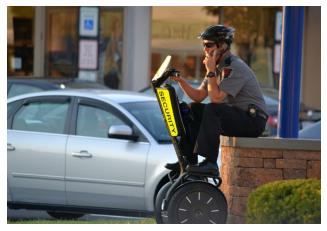

In [22]:
#sample_img = mpl.image.imread(os.path.join(DATA_DIR,"val","car","000000383289.jpg")) # 000000383289
sample_img = mpl.image.imread(os.path.join(DATA_DIR,"val","car","000000383289.jpg")) # 000000383289

plt.figure()
plt.imshow(sample_img)
plt.axis("off")
plt.show()

And see its predictions

In [23]:
IMG_SIZE = (160,160) # small model

In [24]:
resized_img = tf.image.resize(sample_img, IMG_SIZE)/127.5 - 1
prediction = final_model.predict(resized_img[tf.newaxis, ...])

In [25]:
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*prediction.flatten().tolist()))

Scores:
 Car: 0.99, Negative: 0.00, Person: 1.00


Looks good, let's continue with our data pipeline to simulate microcontroller data.

### Dealing with the microcontroller data

> Note: We will be implementing part of the preprocessing in C since some of the ops and data types required are not supported by tensorflow lite. Nevertheless, let's do the whole process in python as well to explore and understand the data pipeline.

Microcontrollers have limited memory, so the cameras that interface with them usually have more compressed color formats than a normal computer would. Indeed, the camera I will be using, OV7670, has "YCbCr 4:2:2"(from which you could extract grayscale images) and RGB565 color modes. The standard RGB your computer uses for most of its work is 8 bits per color channel, so 24 bits are needed per pixel in RGB images. On the other hand, RGB565 uses 5 bits for red, 6 bits for green and another 5 bits for blue, for a total of 16 bits. This is quite convenient since one can store an image in `img_height*img_width /2` 32bit words.

Unfortunately, our model has an input shape of `(160,160,3)` for standard RGB images, so in a first instance we need to be able to convert between RGB888 and RGB555, so let's write a few functions so we can test it works:

In [26]:
import tensorflow.bitwise as bw

def tf_rgb888_2_rgb565(img):
    # Expects a non normalized RGB image [0,255]
    img = tf.cast(img, tf.uint16)
    # Take most significant bits
    r = bw.right_shift(img[..., 0], 3) 
    g = bw.right_shift(img[..., 1], 2)
    b = bw.right_shift(img[..., 2], 3)

    # This is best seen as
    # img565 = (r<<11) | (g<<5) | (b<<0)
    # but in tensorflow ops looks like
    img565 = bw.bitwise_or( bw.bitwise_or(bw.left_shift(r, 11), 
            bw.left_shift(g, 5)), b)
    return img565

In [27]:
def tf_rgb565_2_rgb888(img):
    # Mask each color channel and rescale to the range [0,255]
    r = bw.right_shift(bw.bitwise_and(img, 0xF800), 11) * 255//0x1F
    g = bw.right_shift(bw.bitwise_and(img, 0x7E0), 5) * 255//0x3F
    b = bw.bitwise_and(img, 0x1F) * 255//0x1F
    
    img888 = tf.stack([r, g, b], axis=-1)
    
    return img888

Let's try converting the sample image to RGB565, and back to RGB888 to check everything works as planned.

In [28]:
# Microcontroller captured image resolution
uc_img_size = (240, 160) # the resolution the OV7670 is halved horizontally to reduce RAM usage

In [29]:
sample_img_16 = tf.Variable(sample_img, dtype=tf.uint16)
img_res = tf.image.resize(sample_img_16, uc_img_size)
img_565 = tf.expand_dims(tf_rgb888_2_rgb565(img_res), axis=0)
img_565_flat = tf.reshape(img_565, (1, -1))

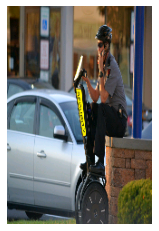

In [30]:
img_888 = tf_rgb565_2_rgb888(img_565)
plt.imshow(tf.squeeze(img_888))
plt.axis("off")
plt.show()

Good, the image looks the same(except for the resolution of course), although in reality we have lost some information in the process: There are more possible colors in 24 bits than in 16 bits, but that shouldn't be a problem.  

As mentioned before we will do some of the preprocessing required in the C code, although it is helpful to see how our model performs on a more natural source of data(i.e raw RGB565 images), so we will do the whole process here as well.

With that said, we need to perform the following preprocessing steps:

1. Reshape a flat `uint16` input of shape `(img_height*img_width)` to `(img_height, img_width)`
2. Convert color from RGB565 to RGB888. Current output shape is `(img_height, img_width, 3)`
3. Normalize the pixels to the range `[-1, 1]`
4. Resize the image to `(input_height, input_width)`. In this case, `(160,160)`. Preprocess output shape is equal to the model input shape, `(160,160,3)`

To do all those steps, let's create our own preprocessing layer:

In [31]:
import tensorflow.bitwise as bw

class PreprocessRGB565(keras.layers.Layer):
    """
    Transforms an RGB565 image of shape `img_size` to an RGB888 normalized [-1, 1] image
    of size `out_img_size`
    
    """
    def __init__(self, img_size, out_img_size):
        super(PreprocessRGB565, self).__init__()
        self.height, self.width = img_size
        self.out_img_size = out_img_size
    
    def build(self, batch_input_shape):
        super().build(batch_input_shape)
    
    def call(self, inputs):
        # Reshape from (batch_size, height*width) to (batch_size, height, width)
        img_565 = tf.reshape(inputs, (-1, self.height, self.width))
        
        # We can convert the color and normalize to the range [-1,1] at the same time changing 
        # the scaling factor once the channel bits are masked. Channels red and blue range from
        # 0 to 2^5 -1 and channel green ranges from 0 to 2^6 -1.
        r = tf.cast(bw.right_shift(bw.bitwise_and(img_565, 0xF800), 11), tf.float32) /15.5 -1
        g = tf.cast(bw.right_shift(bw.bitwise_and(img_565, 0x7E0), 5), tf.float32) /31.5 -1
        b = tf.cast(bw.bitwise_and(img_565, 0x1F), tf.float32) /15.5 -1
        img_888 = tf.stack([r, g, b], axis=-1)
        
        # Resize the image
        res_img = tf.image.resize(img_888, self.out_img_size)
    
        return res_img
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "height": self.height, "width": self.width,
                "out_img_size": self.out_img_size}
    
    

We can now create our "microcontroller" model by adding an input layer and our preprocessing layer before the model:

In [32]:
capture_height, capture_width = uc_img_size

uc_model = keras.models.Sequential([
    keras.layers.InputLayer((capture_height*capture_width), dtype=tf.uint16), # It is important to specify dtype
    PreprocessRGB565(img_size=uc_img_size, out_img_size=IMG_SIZE),
    final_model
])

If we now feed our RGB565 sample image to the network, we should get similar results:

In [33]:
prediction = uc_model.predict(img_565_flat)
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*prediction.flatten().tolist()))

Scores:
 Car: 0.98, Negative: 0.00, Person: 1.00


As explained above, the reconstructed image is not exactly the same to the original due to the smaller RGB format, but as we can see the model still predicts the same classes(remember the threshold is 0.5). If you are surprised the model is so confident on the class scores, it is due to the nature of the macro double soft F1 loss(again, I advise you to read [this post](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d) and the paper linked there).

Let's double-check and evaluate this model on all validation examples

In [34]:
def to_uc_format(img):
    # Transform each image to the microcontroller raw capture format
    non_norm_img = (img+1)*127.5
    resized_img = tf.image.resize(non_norm_img, uc_img_size)
    img_565 = tf_rgb888_2_rgb565(resized_img)
    img_565_flat = tf.reshape(img_565, (-1, 1))
    return img_565_flat

In [35]:
uc_val_ds = val_ds.unbatch().map(lambda x, y: (to_uc_format(x), y)).batch(32)

In [36]:
LOSS = MacroDoubleSoftF1()
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

uc_model.compile(optimizer="SGD", loss=LOSS, metrics=METRICS) #arbitrary optimizer since we are not going to train it

In [37]:
metrics = uc_model.evaluate(uc_val_ds, verbose=0)
print("Loss: {:.2f}, Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, MacroF1: {:.2f}".format(*metrics))

Loss: 0.08, Accuracy: 0.93, Precision: 0.89, Recall: 0.90, MacroF1: 0.90


The performance has slightly decreased, but nothing to worry about; Seems to work quite well. We can confirm this data pipeline is correct and that the model performs well under those conditions.

### A small preprocess layer to include inside our model

Although some operations are not supported by tensorflow lite(or micro), we can get away with image resizing and normalization to make our C code less complex. Let's add that component to our final model by simplifying  the previous preprocess layer:

In [38]:
import tensorflow.bitwise as bw

class uc_preprocess(keras.layers.Layer):
    """
    1. Resize image from `img_size` to `out_img_size`
    2. Normalize to the range [-1,1]
    
    """
    def __init__(self, img_size, out_img_size, **kwargs):
        super(uc_preprocess, self).__init__(**kwargs)
        self.height, self.width = img_size
        self.out_img_size = out_img_size 
    
    def build(self, batch_input_shape):
        super().build(batch_input_shape)
    
    def call(self, inputs):
        # Cast from uint8 to float32 not supported by tflite for microcontrollers as of October, 2020
        # Workaround is to quantize the inputs during compression
        #imgs = tf.cast(inputs, tf.float32) 
        # Resize the image
        res_imgs = tf.image.resize(inputs, self.out_img_size, method='nearest') # method supported by tflite micro
        # Normalize to the range [-1,1]
        norm_imgs = res_imgs*(1/127.5) -1 # multiply reciprocal as DIV is not supported by tflite micro as of October, 2020
    
        return norm_imgs
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "height": self.height, "width": self.width,
                "out_img_size": self.out_img_size}

In [39]:
#Another similar way to do it with a Lambda layer
def lm_uc_preprocess(inputs):
    res_imgs = tf.image.resize(inputs, IMG_SIZE, method='nearest') # method supported by tflite micro
    # Normalize to the range [-1,1]
    norm_imgs = res_imgs*(1/127.5) -1
    return norm_imgs

In [40]:
capture_height, capture_width = uc_img_size

uc_final_model = keras.models.Sequential([
    keras.layers.InputLayer((capture_height, capture_width, 3), dtype=tf.float32),
    uc_preprocess(img_size=uc_img_size, out_img_size=IMG_SIZE), # (240, 160) to (224, 224)
    #keras.layers.Lambda(lm_uc_preprocess),
    *final_model.layers[:-1], # final reshape bugs tflite, so we omit it
    *final_model.layers[-1].layers[:-1]
])

Let's check it works

In [41]:
test_image= tf.expand_dims(tf.image.resize(sample_img, uc_img_size), axis=0)
test_image.shape, test_image.dtype

(TensorShape([1, 240, 160, 3]), tf.float32)

In [42]:
prediction = uc_final_model.predict(test_image)
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*prediction.flatten().tolist()))

Scores:
 Car: 0.98, Negative: 0.00, Person: 1.00


Nice, we can now convert this model.

### Compress the model

In [236]:
def to_input_format(img):
    # Transform each image to the microcontroller capture format
    non_norm_img = (img+1)*127.5 # uint8 range 
    resized_img = tf.image.resize(non_norm_img, uc_img_size)
    return resized_img

In [237]:
input_train_ds = train_ds.unbatch().map(lambda x, y: (to_input_format(x), y)).batch(1)
input_val_ds = val_ds.unbatch().map(lambda x, y: (to_input_format(x), y)).batch(1)

It is time to compress our model to use 8 bit integer parameters to reduce its size and save it in a `tflite` format. To quantize variable data, such as the input or activations, we can provide a representative dataset to estimate the dynamic range of the data.

In [238]:
def representative_data_gen():
    for input_value, label_value in input_train_ds.take(50000):
        yield [input_value]

In [239]:
def compress_and_save(model, name, representative_dataset_gen):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.inference_input_type= tf.int8 # has to be signed (tflite micro requirement)
    converter.inference_output_type = tf.int8
    converter.representative_dataset = representative_data_gen
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open(name, 'wb') as f:
        f.write(tflite_model)
        
    return tflite_model

In [240]:
lite_model = compress_and_save(uc_final_model, "uc_final_model.tflite", representative_data_gen)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Kique\AppData\Local\Temp\tmp_uplohix\assets


As always, let's check the model is still working as expected, but this time with the tflite API:

In [40]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="uc_final_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [41]:
input_type = interpreter.get_input_details()[0]['dtype']
print('input type: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output type: ', output_type)

input type:  <class 'numpy.int8'>
output type:  <class 'numpy.int8'>


In [42]:
# Test the model on random input data.
input_data = tf.cast(test_image-128, tf.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*output_data.flatten().tolist()))

Scores:
 Car: 127.00, Negative: -128.00, Person: 127.00


And evaluate on the whole dataset

In [244]:
def to_tflite_input_format(img):
    # Transform each image to the microcontroller raw capture format
    non_norm_img = (img*127.5)-0.5 # range [-128, 127]
    resized_img = tf.image.resize(non_norm_img, uc_img_size)
    int8_img = tf.cast(resized_img, tf.int8)
    return int8_img

In [245]:
tflite_input_train_ds = train_ds.unbatch().map(lambda x, y: (to_tflite_input_format(x), y)).batch(1)
tflite_input_val_ds = val_ds.unbatch().map(lambda x, y: (to_tflite_input_format(x), y)).batch(1)

In [248]:
def evaluate_tflite_model(interpreter, dataset, metrics): # This will take a while
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    for i, (img_batch, label_batch) in enumerate(dataset):
        interpreter.set_tensor(input_details['index'], img_batch)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details['index'])
        for metric in metrics:
            output_data_norm = tf.reshape((output_data+128)/255, [1, len(class_names)])
            metric.update_state(label_batch, output_data_norm)
        print("Step {} \r".format(i), end="")
        
    for metric in metrics:
        print("\n{}: {:.3f}".format(metric.name, metric.result()))
        
    #return metrics

In [249]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

evaluate_tflite_model(interpreter, tflite_input_val_ds, METRICS)

Step 13901 
bin_accuracy: 0.928

precision: 0.886

recall: 0.900

MacroF1: 0.896


  
Good, now to get our tflite model to a readable C array, we can use `xxd`:

`$ xxd -i uc_final_model.tflite uc_final_model.h`

This creates `uc_model.h`, which looks exactly how we wanted:

```c
unsigned char uc_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, ...};

unsigned int uc_model_tflite_len = 352768;
```

As a side note, remember to add the `const` modifier later. Finally, I would like to export our test image as well to a C readable format

In [43]:
def dump_to_h_file(img, name):
    img = tf.reshape(img, (-1))
    out = "const int8_t test_img[{}] = {{ \n".format(img.shape[0])
    for i in range(img.shape[0]): # there are better ways
        out += str(img.numpy()[i]) + ","
        if (i+1) % 12 == 0:
            out+= "\n"
    out += "};"
    
    with open(name, "wt") as f:
        f.write(out)

In [45]:
dump_to_h_file(tf.squeeze(input_data), "test_image.h")

We can now continue by developing the C code.

# Deployment

For the full code please refer to the repository, but here is a small sample of the code that does the crucial part:

```c++
	if (new_capture){
		new_capture=0;

		// TENSORFLOW
		// Fill input buffer
		uint16_t *pixel_pointer = (uint16_t *)frame_buffer;
		uint32_t input_ix = 0;

		for (uint32_t pix=0; pix<OV7670_QVGA_HEIGHT*OV7670_QVGA_WIDTH/2; pix++){
			// Convert from RGB55 to RGB888 and int8 range
			uint16_t color = pixel_pointer[pix];
			int16_t r = ((color & 0xF800) >> 11)*255/0x1F - 128;
			int16_t g = ((color & 0x07E0) >> 5)*255/0x3F - 128;
			int16_t b = ((color & 0x001F) >> 0)*255/0x1F - 128;

			model_input->data.int8[input_ix] =   (int8_t) r;
			model_input->data.int8[input_ix+1] = (int8_t) g;
			model_input->data.int8[input_ix+2] = (int8_t) b;

			input_ix += 3;
		}

		// Run inference, measure time and report any error
		timestamp = htim->Instance->CNT;
		TfLiteStatus invoke_status = interpreter->Invoke();
		if (invoke_status != kTfLiteOk) {
			TF_LITE_REPORT_ERROR(error_reporter, "Invoke failed");
			return;
		}
		timestamp = htim->Instance->CNT - timestamp;
		car_score = model_output->data.int8[0];
		neg_score = model_output->data.int8[1];
		person_score = model_output->data.int8[2];
		// END TENSORFLOW

		// Display inference information
		Draw_Image((unsigned char*) frame_buffer);
		ILI9341_Set_Rotation(SCREEN_HORIZONTAL_2);
		if (person_score > 0) ILI9341_Draw_Text("PERSON", 180, 210, GREEN, 2, BLACK);
		else ILI9341_Draw_Text("PERSON", 180, 210, RED, 2, BLACK);
		if (car_score >  0) ILI9341_Draw_Text("CAR", 80, 210, GREEN, 2, BLACK);
		else ILI9341_Draw_Text("CAR", 80, 210, RED, 2, BLACK);

		// Print inference info
		buf_len = sprintf(buf,
				"car: %+*d, neg: %+*d, person: %+*d | Duration: %lu ms\r\n",
				4,car_score, 4,neg_score, 4,person_score , timestamp/1000);
		HAL_UART_Transmit(huart, (uint8_t *)buf, buf_len, 100);

		// Capture a new image
		ov7670_startCap(OV7670_CAP_SINGLE_FRAME, (uint32_t)frame_buffer);
	}
```

When a new image is captured by the camera, the model input buffer is filled, transforming the RGB565 frame buffer to RGB888 with the same logic we have applied before. Then, for demonstration purposes, the image and its predictions are displayed on a small LCD screen. The predictions are also printed through UART.

For both the tensor arena buffer needed by tflite micro and the frame buffer to fit in RAM I had to halve the horizontal resolution by two: The DCMI peripheral(in charge of receiving the image) is configured to ignore every other pixel, resulting in an image with size `(QVGA_height, QVGA_width/2) = (240, 160) `  

On an STM32H743, inference takes 1195 ms which is more than enough for the application we have been building.

(TODO further tests and stats)

# References

- [Coco dataset](https://cocodataset.org/#home)
- [CocoAPI for Python3 and Windows](https://github.com/philferriere/cocoapi#egg=pycocotools^&subdirectory=PythonAPI)
- [Visual wake word dataset](https://arxiv.org/abs/1906.05721)
- [Python docs](https://docs.python.org/3/)
- A lot of [stackoverflow](https://stackoverflow.com/)
- [The Unknown Benefits of using a Soft-F1 Loss in Classification Systems](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
- [Handling Data Imbalance in Multi-label Classification (MLSMOTE)](https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87)
- [Tensorflow guides](https://www.tensorflow.org/guide) and [tensorflow tutorials](https://www.tensorflow.org/tutorials)
- [EfficentNet](https://arxiv.org/abs/1905.11946)
- [NASNet](https://arxiv.org/abs/1707.07012)
- [The Unknown Benefits of using a Soft-F1 Loss in Classification Systems](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)
- [Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
- [MIT Indoor dataset](http://web.mit.edu/torralba/www/indoor.html)
